In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import numpy.linalg as npla
import scipy
import scipy.linalg as sla
import pickle
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
%matplotlib inline

from methods.saddle import SaddleSliding, Extragradient, extragradient_solver, Logger, \
    ConstraintsL2
from oracles.saddle import ArrayPair, RobustLinearOracle, create_robust_linear_oracle, \
    OracleLinearComb

from experiment_utils import gen_matrices, gen_oracles_for_sliding, SaddleSlidingRunner, \
    compute_L_delta_mu, solve_with_extragradient, run_experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
n_one = 5
d = 3
num_summands = 4
regcoef_x = 0.2
regcoef_y = 0.2
r_x = 5.
r_y = 5.

In [ ]:
%%time
runner, logger_extragradient = run_experiment(
    n_one=n_one, 
    d=d, 
    noise=10., 
    num_summands=num_summands, 
    regcoef_x=regcoef_x, 
    regcoef_y=regcoef_y, 
    r_x=r_x,
    r_y=r_y, 
    num_iter_solution=500000, 
    max_time_solution=60, 
    tolerance_solution=1e-15, 
    num_iter_experiment=100
)

L = 1417.112, delta = 1266.174, mu = 0.200
Solving with extragradient...


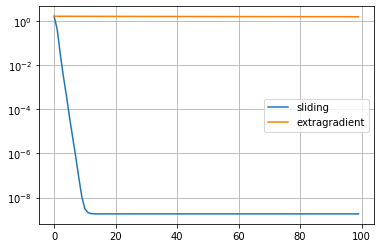

In [6]:
logger_sliding = runner.logger
plt.plot(logger_sliding.dist_to_opt, label='sliding')
plt.plot(logger_extragradient.dist_to_opt, label='extragradient')

plt.yscale('log')
plt.legend()
plt.grid()